### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSSSBSBB' # my index
# file_index = 'BBBSBBBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12816
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     1|[C8 5A E8 59 F0 5...|1897.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[80 58 00 00 20 5...|1898.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[60 59 00 53 40 5...|1899.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     6|[00 C6 00 4F 00 4...|1900.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[28 58 40 56 30 5...|1901.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [4]:
sqlContext.registerDataFrameAsTable(df,'weather')
# Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TMAX','USC00198301')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00018859')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00018859'
108 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       PRCP|USC00018859|    26|[00 00 00 00 00 0...|1894.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       PRCP|USC00018859|     0|[00 00 00 00 50 5...|1895.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(108L, 365L)

In [9]:
Query1="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('SNWD','USC00018859')
print Query1
df2 = sqlContext.sql(Query1)
print df2.count(),'rows'
df2.show(2)
rows1=df2.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T1=np.vstack(rows1)
# T=T/10.  # scaling to make the temperature be in centingrates
shape(T1)

SELECT * FROM weather
	WHERE measurement='SNWD' and station='USC00018859'
57 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       SNWD|USC00018859|     1|[00 00 00 00 00 0...|1949.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       SNWD|USC00018859|     0|[00 00 00 00 00 0...|1950.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(57L, 365L)

In [30]:
Query2="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('TOBS','USC00018859')
print Query2
df3 = sqlContext.sql(Query2)
print df3.count(),'rows'
df3.show(2)
rows2=df3.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T2=np.vstack(rows2)
T2=T2/10.  # scaling to make the temperature be in centingrates
shape(T2)

SELECT * FROM weather
	WHERE measurement='TOBS' and station='USC00018859'
57 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       TOBS|USC00018859|     0|[30 55 30 54 80 5...|1901.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TOBS|USC00018859|     0|[80 C9 80 51 E0 5...|1902.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(57L, 365L)

In [3]:
# my trials

# find all stations
sample_query = "SELECT distinct station FROM weather"
sample_df = sqlContext.sql(sample_query)
print sample_df.count()
sample_df.show(3)

101
+-----------+
|    station|
+-----------+
|USC00014840|
|USC00015785|
|USC00011178|
+-----------+
only showing top 3 rows



### Script for plotting yearly plots

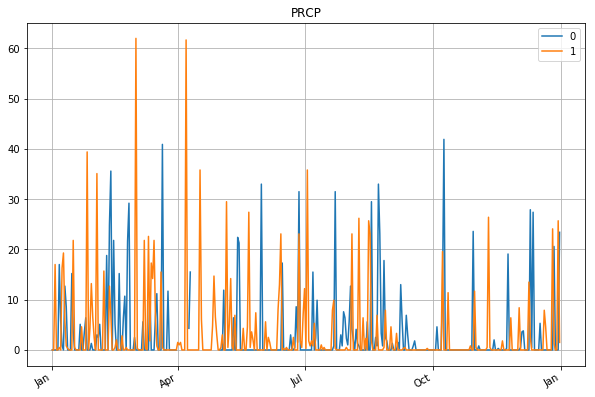

In [5]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

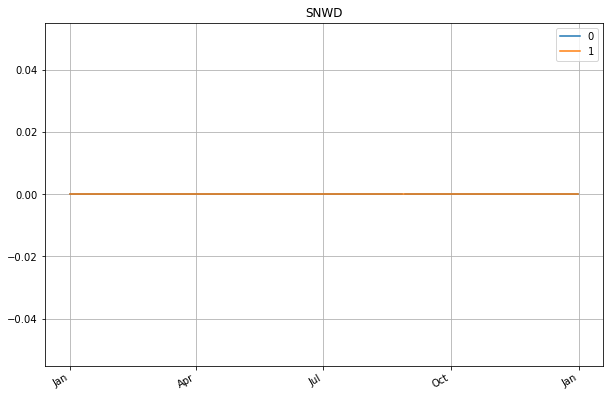

In [14]:
fig, ax = plt.subplots(figsize=(10,7));
YP.plot(T1[:2,:].transpose(),fig,ax,title='SNWD')

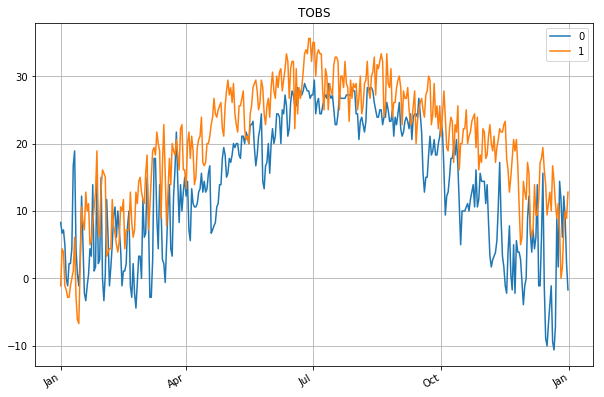

In [31]:
fig, ax = plt.subplots(figsize=(10,7));
YP.plot(T2[:2,:].transpose(),fig,ax,title='TOBS')

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [15]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

C:\Users\udupa\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


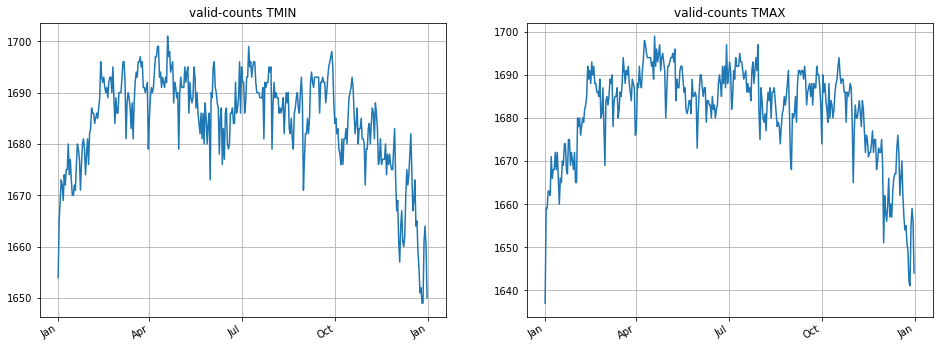

In [16]:
plot_pair(['TMIN','TMAX'],plot_valid)

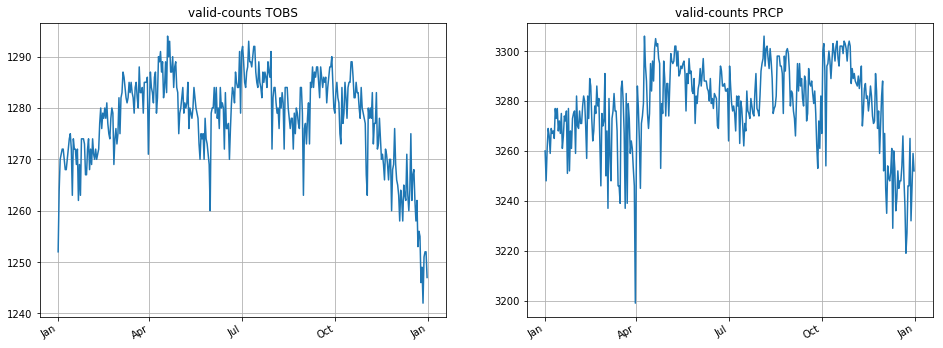

In [17]:
plot_pair(['TOBS','PRCP'],plot_valid)

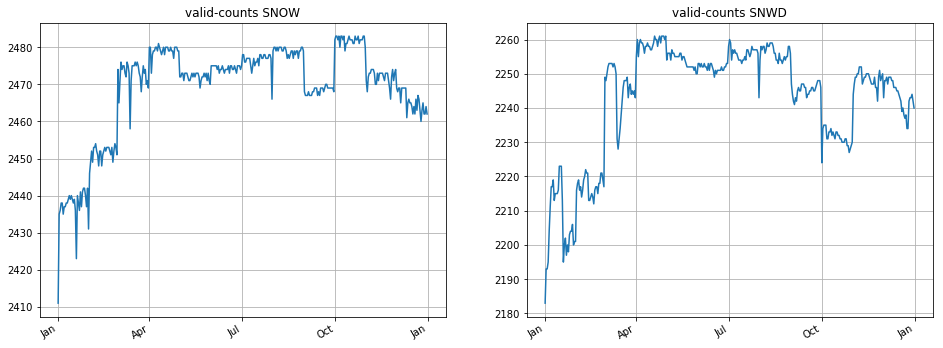

In [18]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [19]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

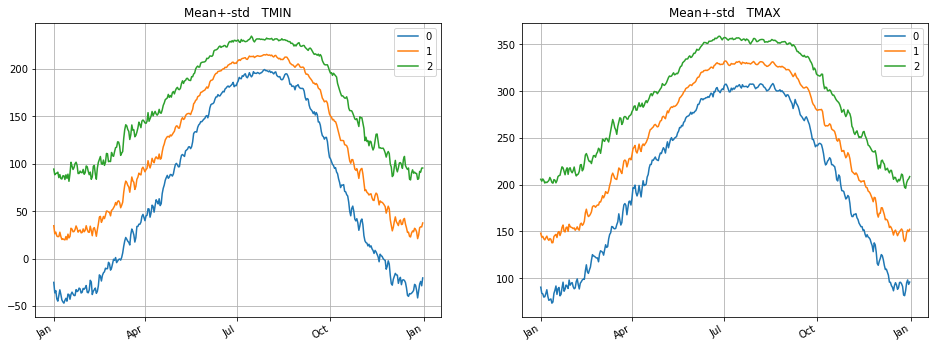

In [20]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

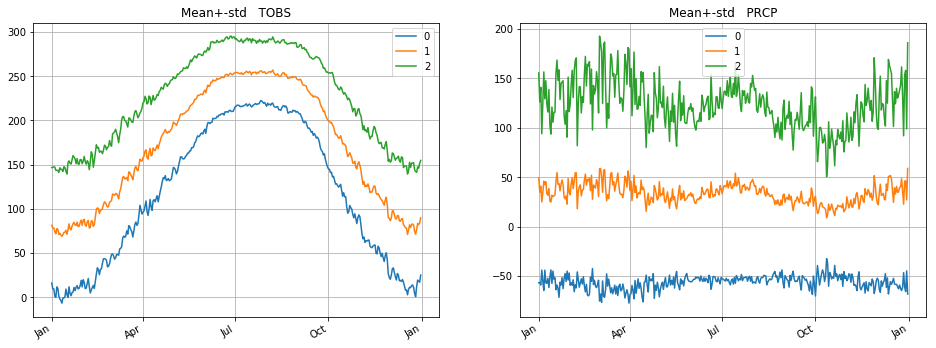

In [21]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

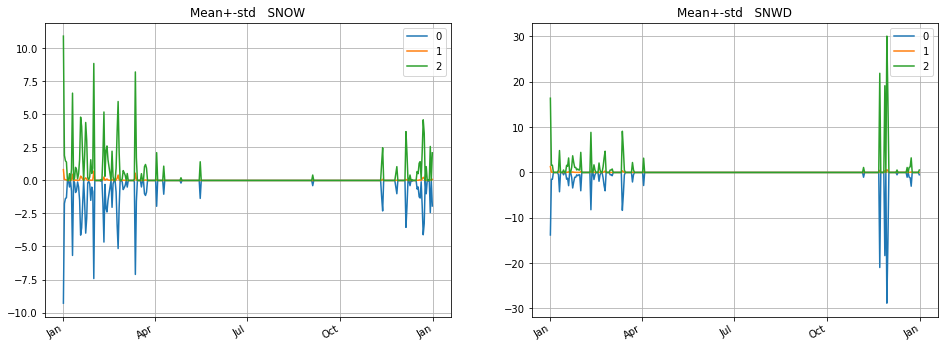

In [22]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [23]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

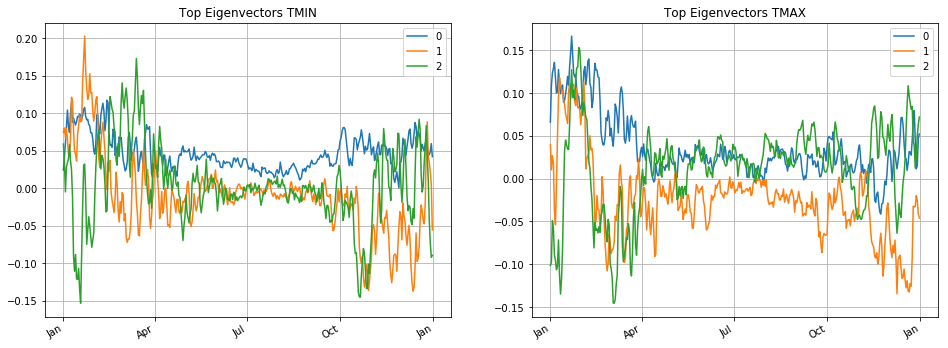

In [24]:
plot_pair(['TMIN','TMAX'],plot_eigen)

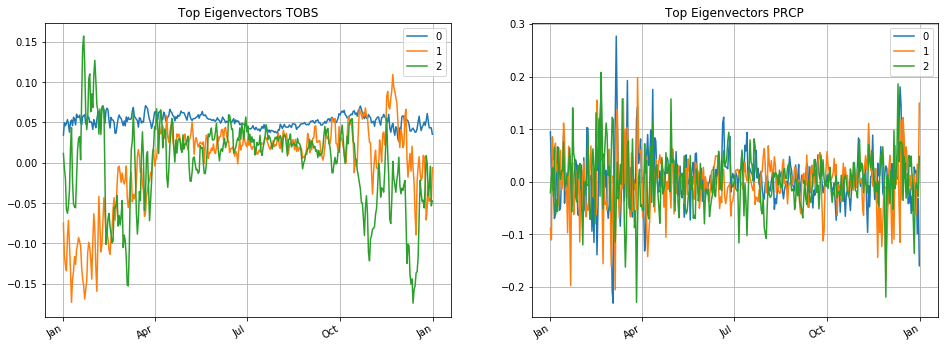

In [25]:
plot_pair(['TOBS','PRCP'],plot_eigen)

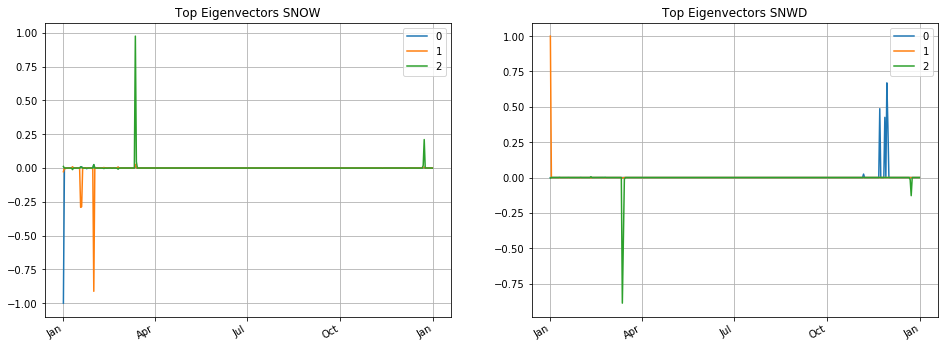

In [26]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [27]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

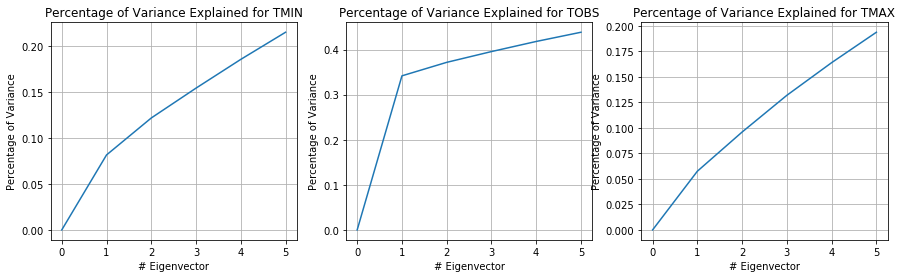

In [28]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

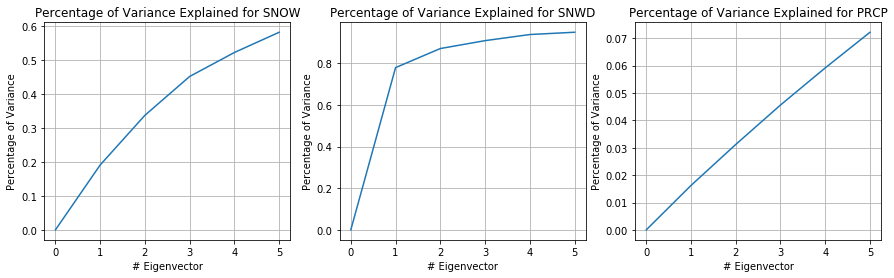

In [29]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [ ]:
#sc.stop()